In [ ]:
!pip install -q torch==1.0.0 torchvision==0.2.2

In [49]:
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from random import shuffle, seed
import numpy as np
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time

%matplotlib inline

In [2]:
use_cuda = False

In [3]:
def get_list_midi(folder = 'maestro-v1.0.0/**/*.midi', seed_int = 666):
    """Get the list of all midi file in the folders

    Parameters
    ==========
    folder : str
    The midi folder.
    seed_int : int
    the random seed.

    Returns
    =======
    The midi files

    """
    list_all_midi = glob.glob(folder)
    seed(seed_int)
    shuffle(list_all_midi)
    return list_all_midi

list_all_midi = get_list_midi()

In [4]:
def generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True):
    """ Generate map (dictionary) of music ( in index ) to piano_roll (in np.array)

    Parameters
    ==========
    list_all_midi : list
        List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    use_tqdm : bool
      Whether to use tqdm or not in the function

    Returns
    =======
    dictionary of music to piano_roll (in np.array)

    """
    assert len(list_all_midi) >= batch_song
    
    dict_time_notes = {}
    process_tqdm_midi = tqdm_notebook(range(start_index, min(start_index + batch_song, len(list_all_midi)))) if use_tqdm else range(start_index,  min(start_index + batch_song, len(list_all_midi)))
    for i in process_tqdm_midi:
        midi_file_name = list_all_midi[i]
        if use_tqdm:
            process_tqdm_midi.set_description("Processing {}".format(midi_file_name))
        try: # Handle exception on malformat MIDI files
            midi_pretty_format = pretty_midi.PrettyMIDI(midi_file_name)
            piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
            piano_roll = piano_midi.get_piano_roll(fs=fs)
            dict_time_notes[i] = piano_roll
        except Exception as e:
            print(e)
            print("broken file : {}".format(midi_file_name))
            pass
    return dict_time_notes

In [5]:
dict_time_notes = generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True)

In [6]:
dict_time_notes[0][:, :50].shape

(128, 50)

In [7]:
def generate_training_data(list_all_midi,  sequence_len = 50, 
                           start_index=0, fs=30, use_tqdm=True, ignore_velocity = True):

    
    dict_time_notes = generate_dict_time_notes(list_all_midi, len(list_all_midi), start_index, fs, use_tqdm)
    
    list_data = []
    for _, value in dict_time_notes.items():
        for i in range(0, value.shape[1], sequence_len):
            sample = value[:, i: i + sequence_len]
            if ignore_velocity:
                sample = np.where(sample > 0, 1, sample)
            if sample.shape[1] == sequence_len:
                list_data.append(sample[:, :sequence_len].T)
                
    return np.array(list_data)

In [9]:
data = generate_training_data(list_all_midi[:100],  sequence_len = 20, 
                           start_index=0, fs=30, use_tqdm=True, ignore_velocity = True)

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()

class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)


In [13]:
CODE_SIZE = 100

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential()

generator.add_module(next(ix), nn.Linear(CODE_SIZE, 1024))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.Linear(1024, 512))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), Reshape([-1, 2, 2, 128]))

generator.add_module(next(ix), nn.ConvTranspose2d(2, 4, kernel_size=(7,2)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(4, 8, kernel_size=(7,2)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.Upsample(scale_factor=(4, 1)))

generator.add_module(next(ix), nn.ConvTranspose2d(8, 4, kernel_size=(7,2)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(4, 2, kernel_size=(5,2)))
generator.add_module(next(ix), nn.ELU())

generator.add_module(next(ix), nn.Conv2d(2, 1, kernel_size=(5,5)))
generator.add_module(next(ix), nn.Sigmoid())


if use_cuda: generator.cuda()

In [39]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    batch = batch.view(batch.shape[0], 1, batch.shape[1], batch.shape[2])
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)
    
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [40]:
discriminator = nn.Sequential()

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill
discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1))
discriminator.add_module('relu1', nn.ReLU())
discriminator.add_module('pool1', nn.MaxPool2d(2))

discriminator.add_module('conv2', nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1))
discriminator.add_module('relu2', nn.ReLU())
discriminator.add_module('pool2', nn.MaxPool2d(2))

discriminator.add_module('flatten', View(-1, 16 * 4 * 32),)

discriminator.add_module("linear1", nn.Linear(16 * 4 * 32, 200))
discriminator.add_module('relu', nn.ReLU())
discriminator.add_module("disc_logit", nn.Linear(200, 1))

if use_cuda: discriminator.cuda()

In [54]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
#     print(generated_data.shape)
    disc_on_generated_data = discriminator(generated_data)

    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)    
    
    loss = - torch.mean(logp_gen_is_real, dim = 0)
    
    return loss

In [55]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([0.8608], grad_fn=<NegBackward>)


In [56]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = - torch.mean(logp_real_is_real, dim = 0) - torch.mean(logp_gen_is_fake, dim = 0)
    return loss

In [57]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([1.2738], grad_fn=<SubBackward0>)


In [58]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3, weight_decay=1e-5)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [68]:
def sample_pianorolls(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i][:, :, 0], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i][:, :, 0], cmap="gray")
    plt.show()
    

    
def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

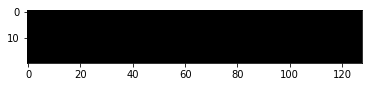

In [69]:
plt.imshow(data[0], cmap="gray")

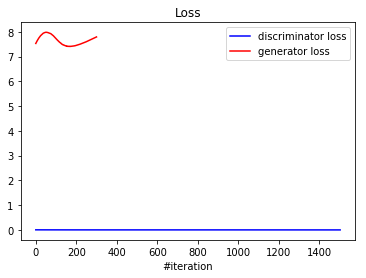

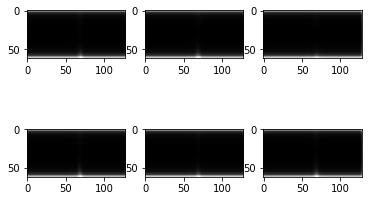

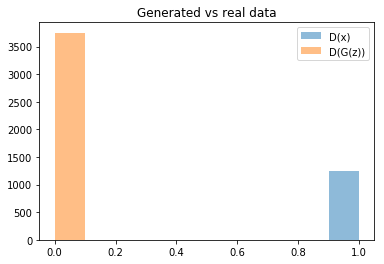

KeyboardInterrupt: 

In [78]:
from IPython import display
from tqdm import tnrange
batch_size = 100

gen_loss_history = []
disc_loss_history = []

for epoch in tnrange(10000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_loss_history.append(loss)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_loss_history.append(loss)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        
        plt.plot(disc_loss_history, 'b', label='discriminator loss')
        plt.plot(gen_loss_history, 'r', label='generator loss')
        plt.title('Loss')
        plt.legend()
        plt.xlabel("#iteration")
        plt.show()
        
        sample_pianorolls(2,3,True)
        sample_probas(1000)

In [79]:
pianorolls = generator(sample_noise_batch(batch_size=7))
pianorolls = pianorolls.data.cpu().numpy().transpose([0, 2, 3, 1])
# if np.var(images)!=0:
#     images = images.clip(np.min(data),np.max(data))
# for i in range(nrow*ncol):
#     plt.subplot(nrow,ncol,i+1)
#     if sharp:
#         plt.imshow(images[i][:, :, 0], cmap="gray", interpolation="none")
#     else:
#         plt.imshow(images[i][:, :, 0], cmap="gray")
# plt.show()

In [108]:
def write_midi_file_from_generated(generate, midi_file_name = "result.mid", fs=20, max_generated=62):
    array_piano_roll = np.zeros((128, max_generated), dtype=np.int16)
    
    for index, notes in enumerate(generate[:, :]):
#         print(notes)
        nonzero_notes = np.nonzero(notes)
        if len(nonzero_notes) > 0:
#             print(nonzero_notes)
            nonzero_notes = nonzero_notes[0]
        else:
            continue

        for j in nonzero_notes:
            print(f'j = {j}, index = {index}')
            array_piano_roll[int(j),index] = 1
#     print(array_piano_roll.sum())
    generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
    for note in generate_to_midi.instruments[0].notes:
        note.velocity = 100
    generate_to_midi.write(midi_file_name)
    
    return array_piano_roll

In [112]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [116]:
for i in range(pianorolls.shape[0]):
    prob_matrix = pianorolls[i][:, :, 0]
    pianoroll_matrix = np.where( prob_matrix > prob_matrix.mean(axis = 1).max() - 0.005, 1, 0)
    write_midi_file_from_generated(pianoroll_matrix, midi_file_name = "gan_{}.mid".format(i),
                                   fs=5, max_generated=62)

j = 0, index = 0
j = 126, index = 0
j = 127, index = 0
j = 0, index = 61
j = 1, index = 61
j = 2, index = 61
j = 3, index = 61
j = 4, index = 61
j = 5, index = 61
j = 6, index = 61
j = 7, index = 61
j = 8, index = 61
j = 9, index = 61
j = 10, index = 61
j = 11, index = 61
j = 12, index = 61
j = 13, index = 61
j = 14, index = 61
j = 15, index = 61
j = 16, index = 61
j = 17, index = 61
j = 18, index = 61
j = 19, index = 61
j = 20, index = 61
j = 21, index = 61
j = 22, index = 61
j = 23, index = 61
j = 24, index = 61
j = 25, index = 61
j = 26, index = 61
j = 27, index = 61
j = 28, index = 61
j = 29, index = 61
j = 30, index = 61
j = 31, index = 61
j = 32, index = 61
j = 33, index = 61
j = 34, index = 61
j = 35, index = 61
j = 36, index = 61
j = 37, index = 61
j = 38, index = 61
j = 39, index = 61
j = 40, index = 61
j = 41, index = 61
j = 42, index = 61
j = 43, index = 61
j = 44, index = 61
j = 45, index = 61
j = 46, index = 61
j = 47, index = 61
j = 48, index = 61
j = 49, index = 61
j = 5